# Modeling and Simulation in Python

Chapter 11

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code

Here's the code from the previous notebook that we'll need.

In [2]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [3]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [4]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [5]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end-1):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

In [6]:
def calc_total_infected(results, system):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    system: System object
    
    returns: fraction of population
    """
    return results.S[system.t0] - results.S[system.t_end]

In [7]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

### Logistic function

To model the effect of a hand-washing campaign, I'll use a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function) (GLF), which is a convenient function for modeling curves that have a generally sigmoid shape.  The parameters of the GLF correspond to various features of the curve in a way that makes it easy to find a function that has the shape you want, based on data or background information about the scenario.

In [8]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

The following array represents the range of possible spending.

In [9]:
spending = linspace(0, 1200, 21)

array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
        540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
       1080., 1140., 1200.])

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20%.

`B` is chosen by trial and error to yield a curve that seems feasible.

In [10]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

Here's what it looks like.

Saving figure to file figs/chap05-fig04.pdf


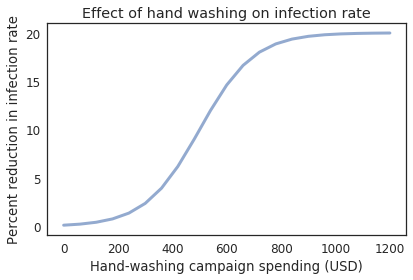

In [11]:
percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

savefig('figs/chap05-fig04.pdf')

**Exercise:** Modify the parameters `M`, `K`, and `B`, and see what effect they have on the shape of the curve.  Read about the [generalized logistic function on Wikipedia](https://en.wikipedia.org/wiki/Generalised_logistic_function).  Modify the other parameters and see what effect they have.

### Hand washing

Now we can model the effect of a hand-washing campaign by modifying `beta`

In [12]:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

Let's start with the same values of `beta` and `gamma` we've been using.

In [13]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

(0.3333333333333333, 0.25)

Now we can sweep different levels of campaign spending.

In [14]:
spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    system = make_system(beta, gamma)
    add_hand_washing(system, spending)
    results = run_simulation(system, update_func)
    print(spending, system.beta, calc_total_infected(results, system))

0.0 0.3328871432717143 0.4667702312363652
100.0 0.3321342526691939 0.46414165040064037
200.0 0.33017160845482885 0.4572170063132055
300.0 0.32538647186519215 0.4398872029120663
400.0 0.3154039052420003 0.40163064627138245
500.0 0.3 0.3370342594898199
600.0 0.28459609475799963 0.26731703056804546
700.0 0.2746135281348078 0.22184699045990752
800.0 0.26982839154517113 0.20079159841614402
900.0 0.2678657473308061 0.1923921833925878
1000.0 0.26711285672828566 0.18921320781833872
1100.0 0.26683150821044227 0.18803175228016467
1200.0 0.26672740341296003 0.1875955039953746


Here's a function that sweeps a range of spending and stores the results in a `SweepSeries`.

In [15]:
def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results, system)
        
    return sweep

Here's how we run it.

In [16]:
spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

,values
0.000000,0.466770
63.157895,0.465418
126.315789,0.462905
189.473684,0.458291
252.631579,0.449980
315.789474,0.435540
378.947368,0.411960
442.105263,0.377183
505.263158,0.333171
568.421053,0.287633


And here's what it looks like.

Saving figure to file figs/chap05-fig05.pdf


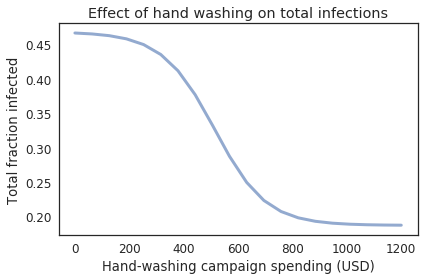

In [17]:
plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections',
         legend=False)

savefig('figs/chap05-fig05.pdf')

Now let's put it all together to make some public health spending decisions.

### Optimization

Suppose we have \$1200 to spend on any combination of vaccines and a hand-washing campaign.

In [18]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses)
max_doses

12

We can sweep through a range of doses from, 0 to `max_doses`, model the effects of immunization and the hand-washing campaign, and run simulations.

For each scenario, we compute the fraction of students who get sick.

In [19]:
for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results, run_simulation(system, update_func)
    print(doses, system.init.S, system.beta, calc_total_infected(results, system))

0.0 0.9888888888888889 0.26672740341296003 0.1875955039953746
1.0 0.9777777777777779 0.26683150821044227 0.1875955039953746
2.0 0.9666666666666667 0.26711285672828566 0.1875955039953746
3.0 0.9555555555555556 0.2678657473308061 0.1875955039953746
4.0 0.9444444444444445 0.26982839154517113 0.1875955039953746
5.0 0.9333333333333333 0.2746135281348078 0.1875955039953746
6.0 0.9222222222222223 0.28459609475799963 0.1875955039953746
7.0 0.9111111111111112 0.3 0.1875955039953746
8.0 0.9 0.3154039052420003 0.1875955039953746
9.0 0.888888888888889 0.32538647186519215 0.1875955039953746
10.0 0.8777777777777778 0.33017160845482885 0.1875955039953746
11.0 0.8666666666666667 0.3321342526691939 0.1875955039953746
12.0 0.8555555555555556 0.3328871432717143 0.1875955039953746


The following function wraps that loop and stores the results in a `Sweep` object.

In [20]:
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results, system)

    return sweep

Now we can compute the number of infected students for each possible allocation of the budget.

In [21]:
infected_sweep = sweep_doses(dose_array)

,values
0,0.187596
1,0.174581
2,0.162910
3,0.153508
4,0.148565
5,0.152946
6,0.174964
7,0.217343
8,0.259071
9,0.278403


And plot the results.

Saving figure to file figs/chap05-fig06.pdf


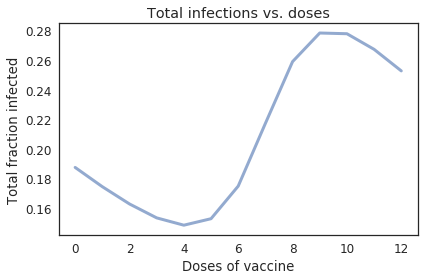

In [22]:
plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

savefig('figs/chap05-fig06.pdf')

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

**Exercise:** Suppose we have the option to quarantine infected students.  For example, a student who feels ill might be moved to an infirmary, or a private dorm room, until they are no longer infectious.

How might you incorporate the effect of quarantine in the SIR model?

In [23]:
# Solution

"""There is no unique best answer to this question,
but one simple option is to model quarantine as an
effective reduction in gamma, on the assumption that
quarantine reduces the number of infectious contacts
per infected student.

Another option would be to add a fourth compartment
to the model to track the fraction of the population
in quarantine at each point in time.  This approach
would be more complex, and it is not obvious that it
is substantially better.

The following function could be used, like 
add_immunization and add_hand_washing, to adjust the
parameters in order to model various interventions.

In this example, `high` is the highest duration of
the infection period, with no quarantine.  `low` is
the lowest duration, on the assumption that it takes
some time to identify infectious students.

`fraction` is the fraction of infected students who 
are quarantined as soon as they are identified.
"""

def add_quarantine(system, fraction):
    """Model the effect of quarantine by adjusting gamma.
    
    system: System object
    fraction: fraction of students quarantined
    """
    # `low` represents the number of days a student 
    # is infectious if quarantined.
    # `high` is the number of days they are infectious
    # if not quarantined
    low = 1
    high = 4
    tr = high - fraction * (high-low)
    system.gamma = 1 / tr